<a href="https://colab.research.google.com/github/bourama1/TH2zp/blob/main/th2zp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Zápočtový úkol TH

## Rozvrhovací problém
Vybral jsem si rozvrhování směn jako příklad rozvrhovacího problému. Zejména proto že se jedná o dosti obecný a všudepřítomný problém.

In [ ]:
!pip install pulp pandas
import random
import pulp
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 39.9 MB/s eta 0:00:00


## Definice hry
Hra se odehrává v prostředí plánování týdenních směn, kde hlavním cílem je efektivně naplnit všechny směny, zatímco se respektují individuální potřeby odpočinku zaměstnanců a jejich preference směn. Efektivní strategie a rozhodování jsou klíčové pro dosažení rovnováhy mezi pracovními požadavky a spokojeností zaměstnanců.

### Hráči
- **Zaměstnanci (E1, E2, E3, ..., En):** Minimálně 4, mohou být i více, každý má za úkol vykonat 4 směny během týdne.

### Preference
- Každý zaměstnanec má za cíl naplnit požadavek 4 směn během týdne a zároveň dodržet pravidlo odpočinku, tedy nemít směny přímo za sebou.
- Zaměstnanci mohou mít preferenci pro denní nebo noční směny nebo preferovat volný víkend, ale hlavním cílem je naplnění všech směn během týdne.
- Každý zaměstnanec si pro jednoduchost vybere preference pro každou směnu jako číslo od 1 do 14, každé číslo smí použít jen jednou.

### Strategie
- **Výběr směn:** Zaměstnanci si vybírají směny tak, aby dodrželi pravidlo odpočinku a zároveň naplnili potřebu pracovat 4 směny. Mohou strategicky preferovat směny v závislosti na jejich osobních preferencích nebo požadavcích.
- **Rotace směn:** Zaměstnanci mohou navrhovat rotaci směn mezi sebou, aby se vyhnuli práci ve směnách přímo za sebou a zároveň naplnili své preferované směny.

### Užitky
- **Maximální spokojenost:** Dosáhne se, pokud zaměstnanec naplní svůj požadavek na 4 směny, dodrží pravidlo odpočinku a zároveň vykoná směny podle svých preferencí.
- **Efektivní naplnění směn:** Cílem je efektivně naplnit všechny směny s ohledem na pravidla odpočinku a minimální počet zaměstnanců.

### Pravidla
- **Dodržování odpočinku:** Mezi jakýmikoli dvěma směnami musí zaměstnanec mít alespoň jednu směnu volno.
- **Omezení na 4 směny za týden:** Každý zaměstnanec musí pracovat 4 směny během týdne, aniž by překročil tento limit.
- **Pokrytí všech směn:** Všechny směny musí být během týdne pokryty.
- **Flexibilní přiřazení založené na celkovém počtu směn:** Maximální i minimální počet přiřazení na směnu se dynamicky upravuje podle celkového počtu zaměstnanců a jejich požadavků na směny, což zajišťuje, že některé směny mohou být přiřazeny vícekrát v závislosti na počtu dostupných směn a celkové potřeby pracovní síly.

In [ ]:
shifts = ['MonDay', 'MonNight', 'TueDay', 'TueNight', 'WedDay', 'WedNight', 'ThuDay', 'ThuNight', 'FriDay', 'FriNight', 'SatDay', 'SatNight', 'SunDay', 'SunNight']

## Algoritmus řešení kombinatorické aukce
Původně jsem si chtěl zvolit pro práci algoritmus Vickrey-Clarke-Groves (VCG). Ale v situaci, kde je 14 směn a 4 zaměstnanci, kde si každý z nich má vybrat 4 směny, přistupujeme k problému, který se liší od typické VCG aukce, protože zde nejde jen o přiřazení každé směny nejvyšší nabídce, ale o rozdělení omezeného počtu směn mezi zaměstnance s dodržením pravidla, že každý zaměstnanec dostane přesně 4 směny [1].

Proto jsem se rozhodl implementovat Mixed Integer Programming (MIP), který by měl být lepší volbou pro řešení tohoto typu problému s přiřazováním směn. MIP umožňuje definovat problém s kombinatorní povahou, kde některé proměnné musí být celočíselné, což se hodí pro situace, kde přiřazujete směny (diskrétní úkoly) zaměstnancům. MIP může efektivně zvládnout složité omezení, jako jsou požadavky na počet směn na zaměstnance, preference a odpočinkové dny [2].

Pro implementaci tohoto algoritmu byla použita knihovna PuLP, která pomáhá s řešením problémů lineárního programování [3].

In [ ]:
def solve_shift_scheduling(shifts, employees):
    # Počet směn, které každý zaměstnanec musí odpracovat
    shifts_per_employee = 4

    # Celkový počet směn, které je třeba odpracovat
    total_shifts_needed = len(employees) * shifts_per_employee

    # Maximální počet přiřazení na směnu
    max_assignments_per_shift = math.ceil(total_shifts_needed / len(shifts))

    # Minimalni počet přiřazení na směnu
    min_assignments_per_shift = math.floor(total_shifts_needed / len(shifts))

    # Vytvoření problému
    prob = pulp.LpProblem("ShiftScheduling", pulp.LpMaximize)

    # Definice proměnných - binární proměnné pro každou možnou dvojici zaměstnanec-směna
    assignment_vars = {(e[0], s): pulp.LpVariable(f"{e[0]}_{s}", cat='Binary')
                       for e in employees for s in shifts}

    # Cílová funkce - maximalizace celkové spokojenosti zaměstnanců na základě jejich preferencí
    prob += pulp.lpSum([e[1][s] * assignment_vars[e[0], s]
                        for e in employees for s in shifts if s in e[1]])

    # Omezení - každá směna přiřazena maximálně max_assignments_per_shift krát
    for s in shifts:
        prob += pulp.lpSum([assignment_vars[e[0], s] for e in employees if s in e[1]]) <= max_assignments_per_shift, f"Shift_{s}_max_{max_assignments_per_shift}"

    # Omezení - každá směna přiřazena minimalne min_assignments_per_shift krát
    for s in shifts:
        prob += pulp.lpSum([assignment_vars[e[0], s] for e in employees if s in e[1]]) >= min_assignments_per_shift, f"Shift_{s}_min_{min_assignments_per_shift}"

    # Omezení - každý zaměstnanec dostane přesně shifts_per_employee směn
    for e in employees:
        prob += pulp.lpSum([assignment_vars[e[0], s] for s in shifts if s in e[1]]) == shifts_per_employee, f"Employee_{e[0]}_{shifts_per_employee}_shifts"

    # Omezení - zaměstnanec nemá směny hned po sobě
    for e in employees:
        for i in range(len(shifts) - 1):
            s1, s2 = shifts[i], shifts[i + 1]
            if s1 in e[1] and s2 in e[1]:
                prob += assignment_vars[e[0], s1] + assignment_vars[e[0], s2] <= 1, f"Consecutive_{e[0]}_{s1}_{s2}"

    # Řešení problému
    prob.solve()

    # Výpis výsledků
    results = []
    for e in employees:
        for s in shifts:
            if (e[0], s) in assignment_vars and pulp.value(assignment_vars[e[0], s]) == 1:
                results.append((e[0], s))
    return results

## Rozhraní modelu
Možné určit:
- num_of_empl = počet zaměstnanců ; <4;inf>
- preference zaměstnanců
  - employee_id = název zaměstnance kterému chci změnit preference = 'E1', 'E2', 'E3'...
  - employee_preferences = preference daného zaměstnance
    - formát = `{'MonDay' : 1, 'MonNight' : 2, 'TueDay' : 3, 'TueNight' : 4, 'WedDay' : 5, 'WedNight' : 6, 'ThuDay' : 7, 'ThuNight' : 8, 'FriDay' : 9, 'FriNight' : 10, 'SatDay' : 11, 'SatNight' : 12, 'SunDay' : 13, 'SunNight' : 14}`
    - číslo po směně = platba za směnu => vyšší znamená vyšší preferenci ; čísla 1-14 každé pouze jednou
  - možné kombinací předchozích dvou parametrů určit jakýmkoliv zaměstnancům, klidně všem, kdo to nebude mít zvolené dostane vygenerováno náhodně

In [ ]:
def generate_employees(n):
    """
    Generuje seznam zaměstnanců na základě zadaného počtu n.
    Každý zaměstnanec je reprezentován jako dvojice, kde první prvek je ID zaměstnance a druhý prvek
    je slovník, který bude později použit pro přidání preferencí.

    Parametry:
    n (int): Počet zaměstnanců k vygenerování.

    Vrátí:
    List[tuple]: Seznam zaměstnanců s možností přidání preferencí.
    """
    if n < 4:
        raise ValueError("Počet zaměstnanců musí být minimálně 4.")

    # Vytvoření seznamu zaměstnanců bez předem určených preferencí
    employees = [(f"E{i+1}", {}) for i in range(n)]  # Prázdný slovník pro preferenci

    return employees

def generate_random_preferences():
    """
    Generuje náhodné preference pro směny pro zaměstnance s unikátní prioritou od 1 do 14
    pro každý den a noční směnu.

    Vrátí:
    Dict[str, int]: Slovník reprezentující preference pro směny s unikátními prioritami.
    """

    # Generuje list priorit od 1 do 14
    priorities = random.sample(range(1, 15), 14)

    # Přiřadí každé směně náhodnou prioritu
    preferences = {shift: priority for shift, priority in zip(shifts, priorities)}

    return preferences

def set_employee_preferences(employees):
    """
    Nastaví preference pro zaměstnance, buď náhodně nebo na základě předem určených hodnot.

    Parametry:
    employees (List[tuple]): Seznam dvojic (ID zaměstnance, slovník preferencí).

    Vrátí:
    List[tuple]: Seznam dvojic (ID zaměstnance, aktualizovaný slovník preferencí).
    """
    updated_employees = []
    for employee_id, preferences in employees:
        if not preferences:  # Pokud zaměstnanec nemá určené preference
            preferences = generate_random_preferences()
        updated_employees.append((employee_id, preferences))
    return updated_employees

def assign_preferences_to_employee(employee_id, preferences, employees):
    """
    Přiřadí specifikované preference určitému zaměstnanci v seznamu zaměstnanců.

    Parametry:
    employee_id (str): Identifikátor zaměstnance, kterému se mají přiřadit preference.
    preferences (Dict[str, int]): Slovník preferencí pro směny.
    employees (List[tuple]): Seznam dvojic zaměstnanců a jejich aktuálních preferencí.

    Vrátí:
    List[tuple]: Aktualizovaný seznam zaměstnanců s přiřazenými preferencemi.
    """
    updated_employees = []
    for emp_id, emp_preferences in employees:
        if emp_id == employee_id:
            # Nahradíme prázdný slovník preferencemi pro daného zaměstnance
            updated_employees.append((emp_id, preferences))
        else:
            updated_employees.append((emp_id, emp_preferences))
    return updated_employees

### Zde menit parametry
# num_of_empl
num_of_empl = 16
employees = generate_employees(num_of_empl)
print(employees)

# employee_id a employee_preferences !dodrzovat format
employee_id = 'E1'
employee_preferences = {'MonDay' : 1, 'MonNight' : 2, 'TueDay' : 3, 'TueNight' : 4, 'WedDay' : 5, 'WedNight' : 6, 'ThuDay' : 7, 'ThuNight' : 8, 'FriDay' : 9, 'FriNight' : 10, 'SatDay' : 11, 'SatNight' : 12, 'SunDay' : 13, 'SunNight' : 14}
employees = assign_preferences_to_employee(employee_id, employee_preferences, employees)
# zbytek employees dostane preference nahodne
employees = set_employee_preferences(employees)
print(employees)

[('E1', {}), ('E2', {}), ('E3', {}), ('E4', {}), ('E5', {}), ('E6', {}), ('E7', {}), ('E8', {}), ('E9', {}), ('E10', {}), ('E11', {}), ('E12', {}), ('E13', {}), ('E14', {}), ('E15', {}), ('E16', {})]
[('E1', {'MonDay': 1, 'MonNight': 2, 'TueDay': 3, 'TueNight': 4, 'WedDay': 5, 'WedNight': 6, 'ThuDay': 7, 'ThuNight': 8, 'FriDay': 9, 'FriNight': 10, 'SatDay': 11, 'SatNight': 12, 'SunDay': 13, 'SunNight': 14}), ('E2', {'MonDay': 11, 'MonNight': 9, 'TueDay': 10, 'TueNight': 3, 'WedDay': 12, 'WedNight': 7, 'ThuDay': 4, 'ThuNight': 14, 'FriDay': 5, 'FriNight': 1, 'SatDay': 6, 'SatNight': 13, 'SunDay': 8, 'SunNight': 2}), ('E3', {'MonDay': 4, 'MonNight': 2, 'TueDay': 10, 'TueNight': 6, 'WedDay': 11, 'WedNight': 12, 'ThuDay': 1, 'ThuNight': 7, 'FriDay': 13, 'FriNight': 3, 'SatDay': 5, 'SatNight': 9, 'SunDay': 14, 'SunNight': 8}), ('E4', {'MonDay': 12, 'MonNight': 1, 'TueDay': 9, 'TueNight': 10, 'WedDay': 3, 'WedNight': 6, 'ThuDay': 7, 'ThuNight': 8, 'FriDay': 5, 'FriNight': 14, 'SatDay': 4, 'S

## Výsledky
TODO - popis

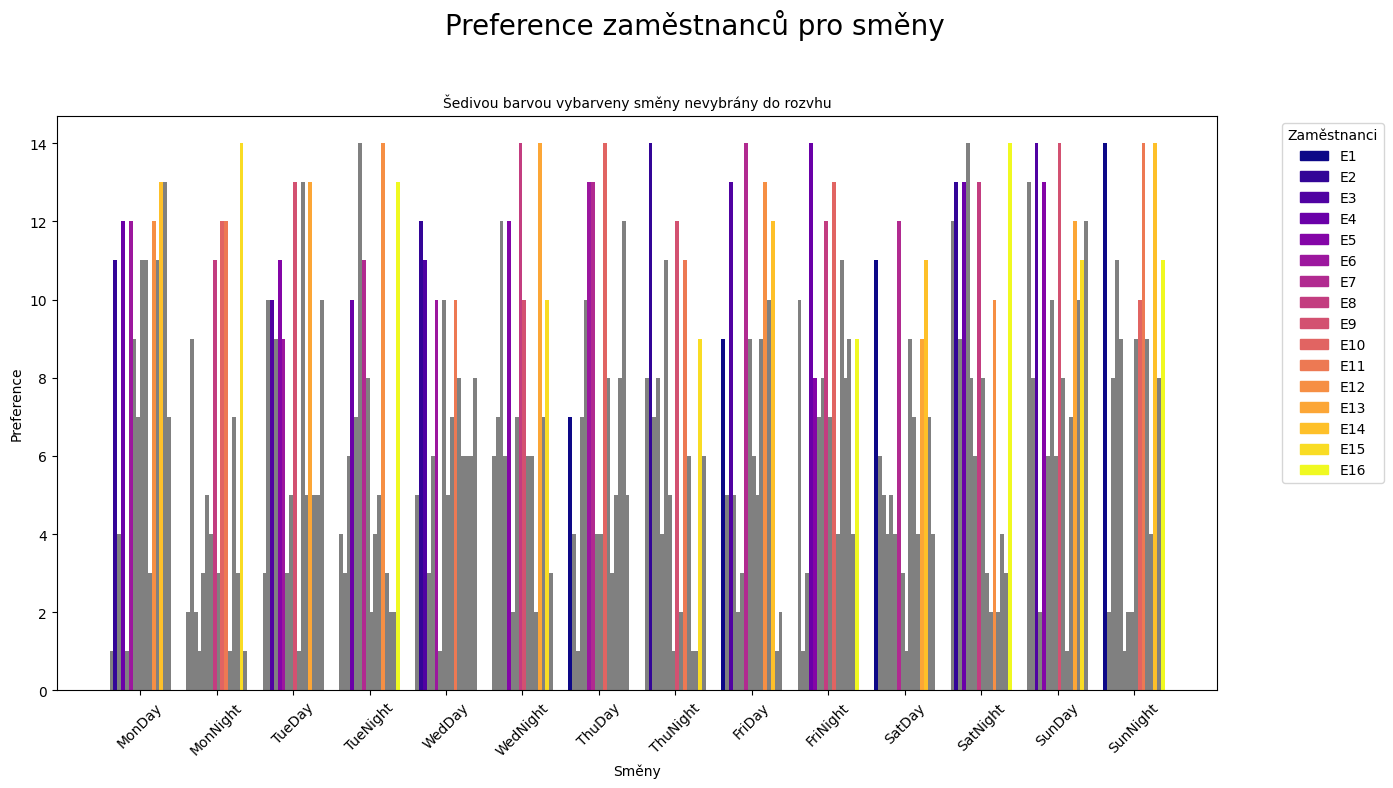

In [ ]:
results = solve_shift_scheduling(shifts, employees)

# Konverze výsledků na DataFrame
df = pd.DataFrame(results, columns=['Employee', 'Shift'])

# Přidání preferencí do DataFrame
df['Preference'] = df.apply(lambda row: employees[[e[0] for e in employees].index(row['Employee'])][1][row['Shift']], axis=1)

# Příprava dat pro graf
num_shifts = len(shifts)
num_employees = len(employees)
index = np.arange(num_shifts)

# Dynamicky upravíme šířku sloupců a velikost grafu
bar_width = max(0.8 / num_employees, 0.05)
fig_width = max(14, num_shifts * num_employees * bar_width / 2)

# Vytvoření grafu s dynamickou velikostí
fig, ax = plt.subplots(figsize=(fig_width, 8))
colors = plt.cm.plasma(np.linspace(0, 1, num_employees))  # Generování barev pro zaměstnance ; pouziti palety plasma pro jednoduche rozliseni od sede

# Nastavení hlavního titulku a podtitulku
fig.suptitle('Preference zaměstnanců pro směny', fontsize=20)
ax.set_title('Šedivou barvou vybarveny směny nevybrány do rozvhu', fontsize=10)

for i, (employee_id, preferences) in enumerate(employees):
    preferences_values = [preferences[shift] for shift in shifts]
    assigned_shifts = df[df['Employee'] == employee_id]['Shift'].tolist()  # Vybrané směny pro zaměstnance

    for j, shift in enumerate(shifts):
        color = 'gray'  # šedá barva pro nepřiřazené směny
        if shift in assigned_shifts:
            color = colors[i]  # Nastavení specifické barvy pro přiřazenou směnu
        ax.bar(index[j] + i * bar_width, preferences_values[j], bar_width, color=color)

# Nastavení osy X a Y
ax.set_xlabel('Směny')
ax.set_ylabel('Preference')
ax.set_xticks(index + bar_width * num_employees / 2 - bar_width / 2)
ax.set_xticklabels(shifts, rotation=45)

# Přidání legendy
ax.legend([plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i, _ in enumerate(employees)],
          [e[0] for e in employees], title="Zaměstnanci", bbox_to_anchor=(1.05, 1), loc='upper left')

# Zobrazení grafu
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Zdroje

1. Yu, H. (2023) Lecture 19: Combinatorial auctions, Princeton Edu. Available at: https://www.cs.princeton.edu/~hy2/teaching/fall23-cos521/notes/Combinatorial%20Auctions.pdf (Accessed: 20 March 2024).

2. Andersson, A. (2003). Combinatorial Auctions, an Example of Algorithm Theory in Real Life. Computer Science in Perspective, 13-21. doi:10.1007/3-540-36477-3_2

3. https://coin-or.github.io/pulp/#